In [1]:
using Revise, UnboundedBNN, Plots, Random, Optimisers, ProgressMeter, Zygote, LinearAlgebra

In [2]:
function generate_samples(N, ω; seed=42, T=Float32)
    t = rand(MersenneTwister(seed), T, N)
    u = sqrt.(t)
    y = rand(MersenneTwister(seed), (-1, 1), N)
    x = zeros(2, N)
    for n in 1:N
        tmp = randn(MersenneTwister(seed+n), T, 2)
        x[1, n] = y[n] * u[n] * cos(ω * u[n] * pi / 2) + convert(T, 0.02) * tmp[1]
        x[2, n] = y[n] * u[n] * sin(ω * u[n] * pi / 2) + convert(T, 0.02) * tmp[2]
    end
    return x, y
end


generate_samples (generic function with 1 method)

In [3]:
# N = 1024
N = 8192
ω = 10
x_train, y_train = generate_samples(N, ω)
x_test,  y_test  = generate_samples(N, ω; seed=123456)

([-0.5529575347900391 0.5210639238357544 … 0.23389983177185059 -0.7339015007019043; -0.23756860196590424 -0.18517586588859558 … 0.6408566832542419 -0.30568110942840576], [1, -1, -1, -1, -1, -1, 1, 1, 1, -1  …  -1, 1, -1, 1, -1, 1, -1, 1, -1, -1])

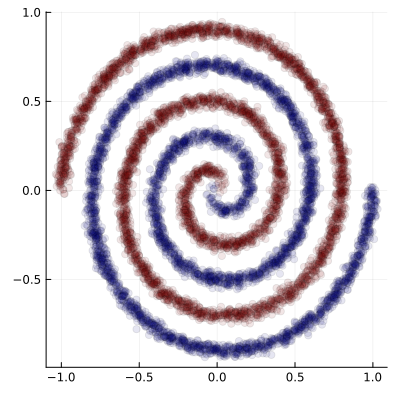

In [4]:
plot(x_train[1,:], x_train[2,:], seriestype=:scatter, zcolor=y_train, legend=false, color=:jet; alpha=0.1, size=(400, 400))

In [5]:
function crossentropy(p::Vector, q::Matrix)
    mask = p .== 1
    return - mapreduce(n -> q[mask[n]+1,n], +, 1:length(p))
end

crossentropy (generic function with 1 method)

In [6]:
function loss(y, x, model; batch_prop = 1.0)
    
    post_support = UnboundedBNN.support(model.posterior)
    post_pdf = UnboundedBNN.pdf.(Ref(model.posterior), post_support)

    output = model(x)
    logln = mapreduce(l -> output[l] .* post_pdf[l], +, 1:length(post_pdf))

    kl_poisson = KL_loss(model.posterior, model.prior)
    kl_input = KL_loss(model.input_layer)
    kl_hidden = mapreduce(l -> dot(post_pdf[1:l], KL_loss.(model.output_layers[1:l])), +, 1:length(post_pdf))
    kl_output = mapreduce(l -> post_pdf[l] * KL_loss(model.output_layers[l]), +, 1:length(post_pdf))
    kl_total = kl_poisson + kl_input + kl_output + kl_hidden

    return crossentropy(y, logln) + batch_prop * kl_total
    
end

loss (generic function with 1 method)

In [7]:
dimin = 2
dimmid = 32
dimout = 2

max_layers = 20

expansion_layer = Chain(LinearSpike(dimin => dimmid), LeakyReLU())
intermediate_layer = ntuple(_ -> Chain(LinearSpike(dimmid => dimmid), LeakyReLU()), max_layers)
output_layer = ntuple(_ -> Chain(LinearSpike(dimmid => dimout), Softmax(dimout)), max_layers)
prior = Poisson(0.5)
posterior = SafeTruncatedPoisson([UnboundedBNN.invsoftplus(1f0)])
model = UnboundedSingle(expansion_layer, intermediate_layer, output_layer, prior, posterior)

opt = Optimisers.setup(Adam(), model)
Optimisers.adjust!(opt, 0.005f0)
Optimisers.adjust!(opt.posterior, 0.0005f0)

In [43]:
epochs = 1000
batch_size = 256
loss_train = zeros(epochs)
loss_test  = zeros(epochs)
gs = nothing
@showprogress for e in 1:epochs
    for n in Iterators.partition(randperm(N), batch_size)
        _, gs = Zygote.withgradient(m -> loss(y_train[n], x_train[:,n], m; batch_prop = length(n)/N), model)
        opt, model = Optimisers.update!(opt, model, gs[1])
    end
    loss_train[e] = loss(y_train, x_train, model)
    loss_test[e] = loss(y_test, x_test, model)
end

Progress:  79%|████████████████████████████████▎        |  ETA: 0:03:27Excessive output truncated after 524311 bytes.

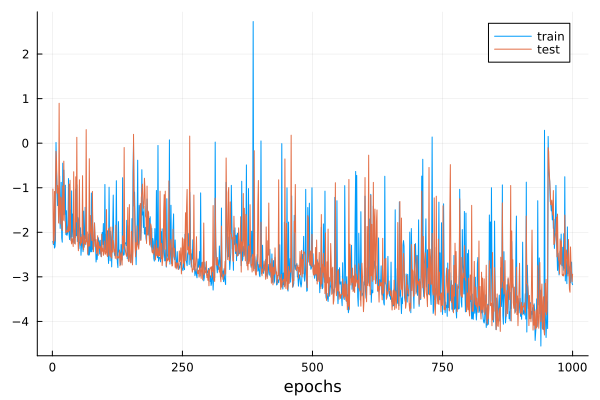

In [44]:
plot(log.(loss_train) .- log(N), label="train")
plot!(log.(loss_test) .- log(N), label="test")
xlabel!("epochs")

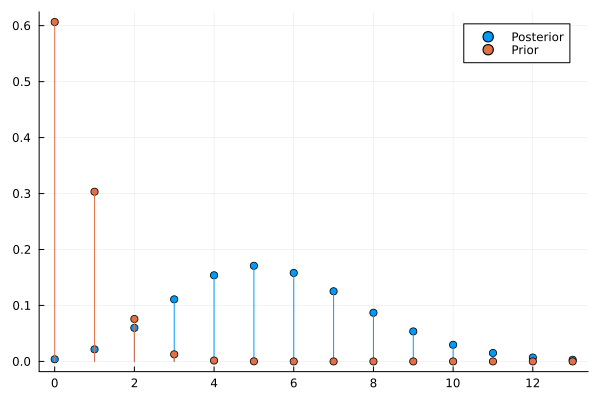

In [45]:
plot(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.posterior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Posterior")
plot!(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.prior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Prior")

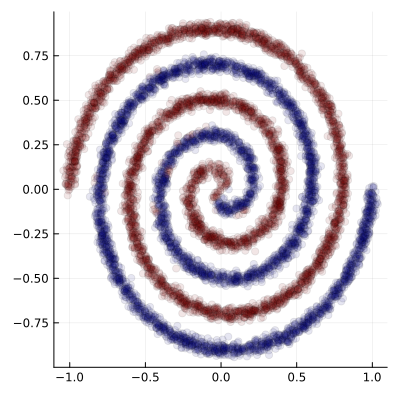

In [46]:
post_support = UnboundedBNN.support(model.posterior)
post_pdf = UnboundedBNN.pdf.(Ref(model.posterior), post_support)

output = model(x_test)
logln = mapreduce(l -> output[l] .* post_pdf[l], +, 1:length(post_pdf))
predictions = mapslices(x -> argmax(x), logln; dims=1)

println("Accuracy: ", sum((predictions .* 2 .- 3)' .== y_test) / N)
plot(x_test[1,:], x_test[2,:], seriestype=:scatter, zcolor=predictions', legend=false, color=:jet; alpha=0.1, size=(400, 400))

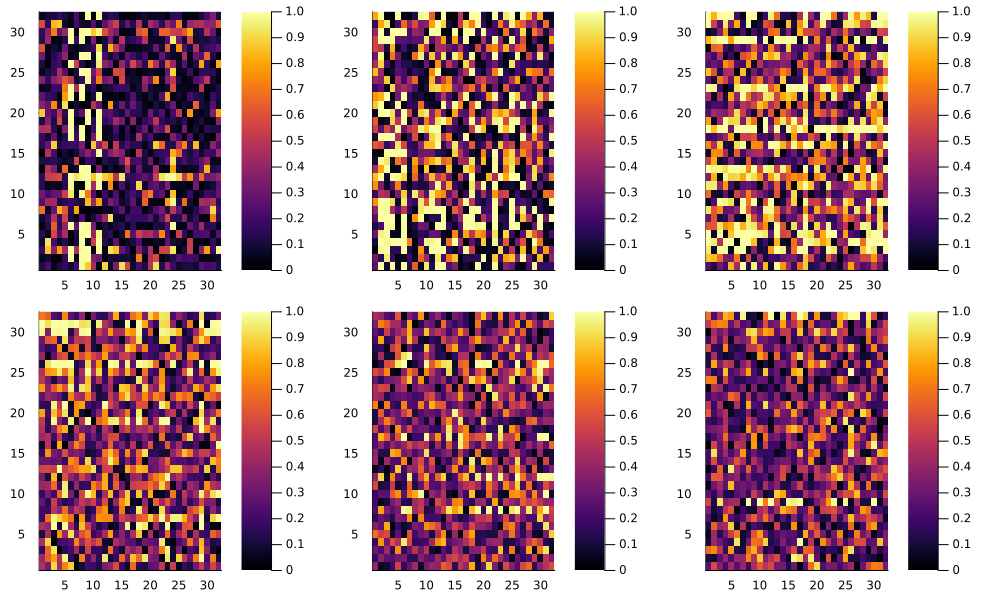

In [47]:
p1 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[1].layers[1].zW), clim = (0,1))
p2 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[2].layers[1].zW), clim = (0,1))
p3 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[3].layers[1].zW), clim = (0,1))
p4 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[4].layers[1].zW), clim = (0,1))
p5 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[5].layers[1].zW), clim = (0,1))
p6 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[6].layers[1].zW), clim = (0,1))
plot(p1, p2, p3, p4, p5, p6, layout = (2,3), size = (1000, 600))